In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_row", 110)
pd.set_option("display.max_column", 110)

In [3]:
data = pd.read_excel("01x - dataset.xlsx", index_col=0, encoding = "ISO-8859-1")

In [4]:
data.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


# 1. Exploratory Data Analysis #

## Objectif : ##

- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arrière)
- Développer une première stratégie de modélisation

## Checklist de base ##

### Analyse de la forme : ###

- **variable target** : SARS-Cov-2 exam result
- **lignes et colonnes** : (5644, 110)
- **types de variables** : qualitatives : 70, quantitatives : 40
- **analyse des valeurs manquantes** : beaucoup de NaN (moitié des variables > 90% de NaN), 2 groupes de données 76% -> test viral, 89% -> test sanguin

### Analyse de fond : ###

- **visualisation de la target** : 10% de positifs, 90% de négatifs
- **signification des variables** : 
    - variables continues standardisées, skewed (asymétriques), test sanguin
    - age quantile : difficile à interpréter, données traitées, peut-être 0-5 ou transformation mathématique
    - variables qualitatives : binaires (0, 1), viral, Rhinovirus semble très élevé
- **relation variables/target** :
    - target/blood : les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 -> hypothèse à tester
    - target/age : les individus d'age faible semblent peu touchés
    - target/viral : double maladies très rares ; Rhinovirus/Enterovirus positif = covid-19 négatif ? à tester mais possibilité d'épidémie de ces virus ; a priori pas de lien avec le covid-19
    
### Analyse plus détaillée : ###

- **relation variables/variables** :
    - blood_data/blood_data : certaines variables très corrélées : +0.9
    - blood_data/age : très faible corrélation entre âge et taux sanguins 
    - viral/viral : influenza rapid test donne de mauvais résultats, il faudra peut-être la laisser tomber
    - maladie/blood_data : les taux sanguins entre malades et covid-19 sont différents
    - hospitalisation/est_malade
    - hospitalisation/blood : intéressant dans le cas où on veut prédire dans quel service un patient devrait aller
- **NaN analyse** : viral : 1350(92/8), blood : 600(87/13), both : 90

### Hypothèses nulles (H0) : ### 
- les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents
    - H0 = les taux moyens sont EGAUX chez les individus positifs et négatifs -> rejetée
- les individus atteints d'une quelconque maladie ont des taux significativement différents

## 1.1. Analyse de la forme ##

In [7]:
df = data.copy()

In [8]:
df.shape

(5644, 110)

In [9]:
df.dtypes.value_counts()

float64    70
object     36
int64       4
dtype: int64

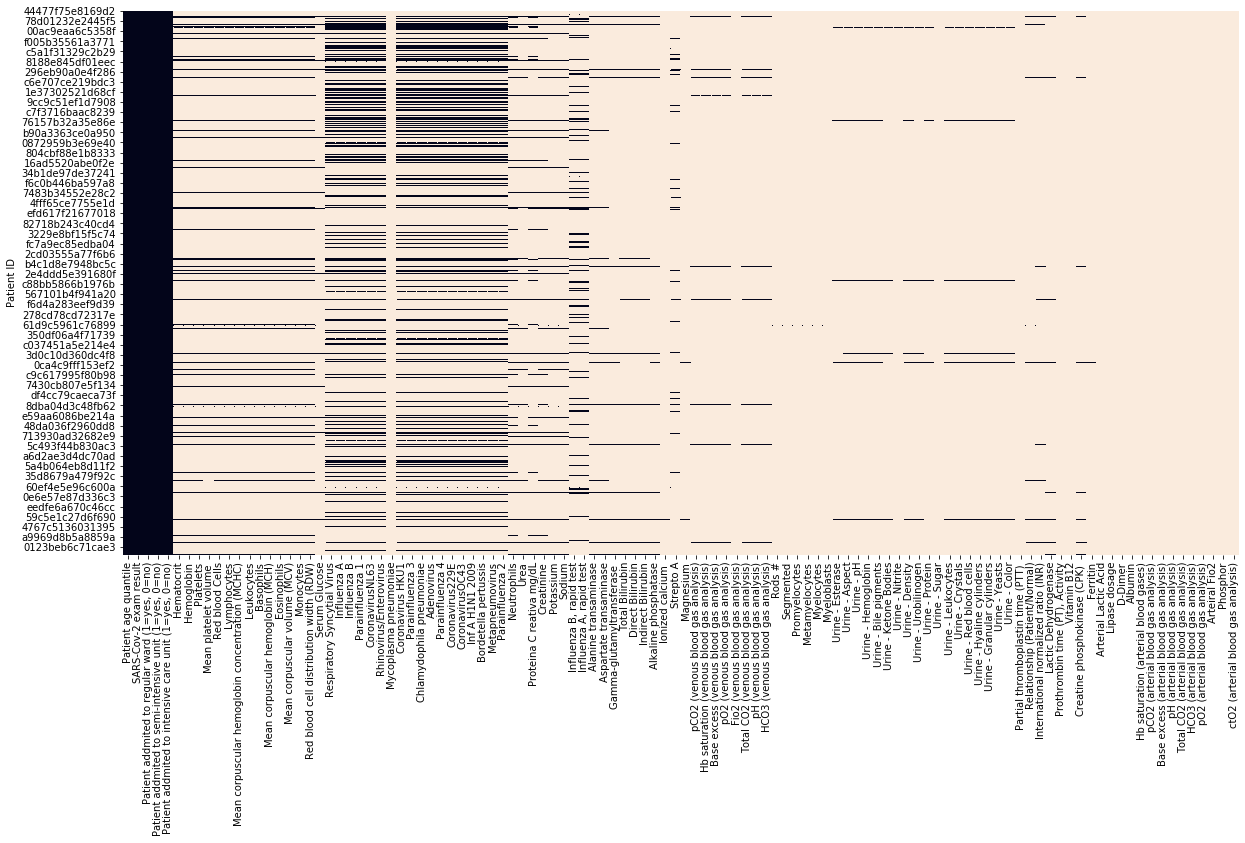

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [11]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydophila pneumoniae                                 0.760454
Parainflue

## 1.2. Analyse du fond ##

### Visualiation initiale - élimination des colonnes inutiles ###

In [12]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.9]]

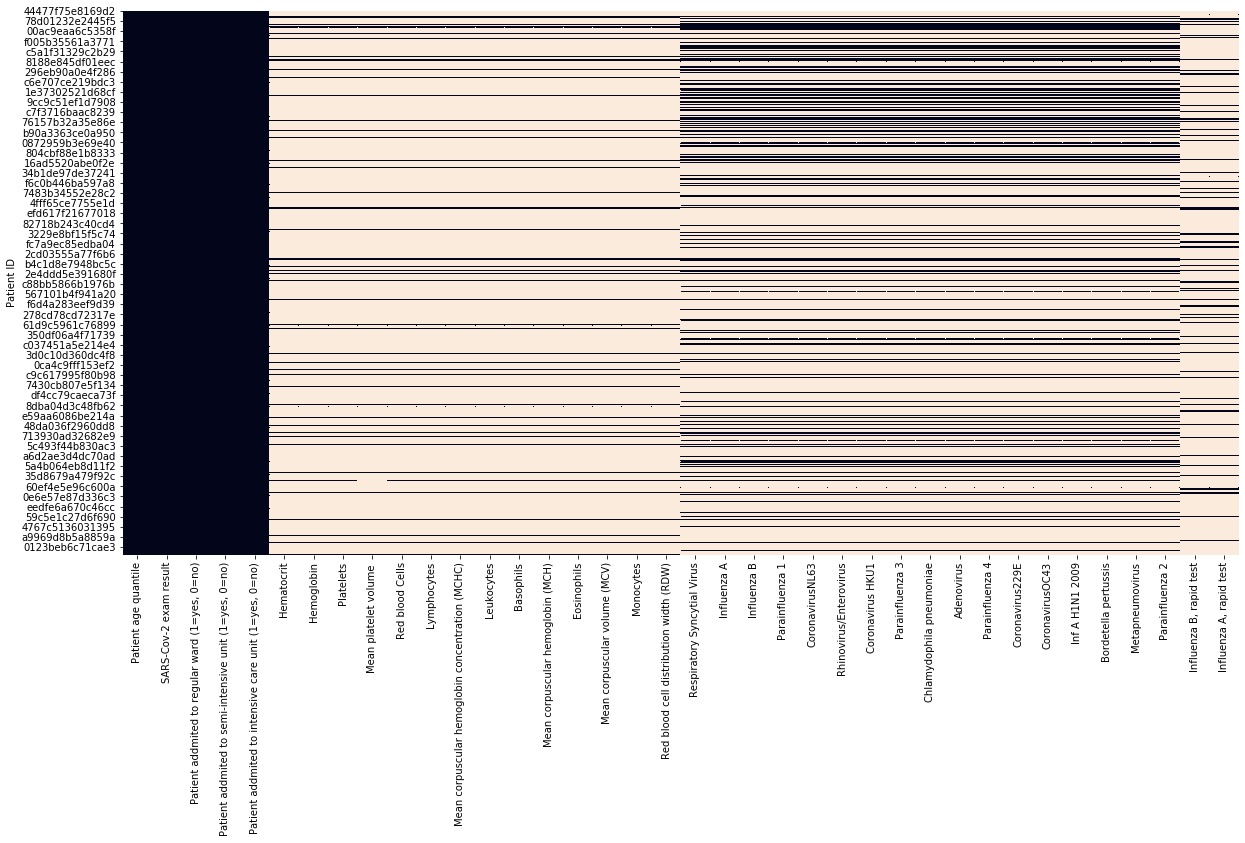

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [14]:
df["SARS-Cov-2 exam result"].value_counts(normalize=True)

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

### Histogramme des variables continues ###

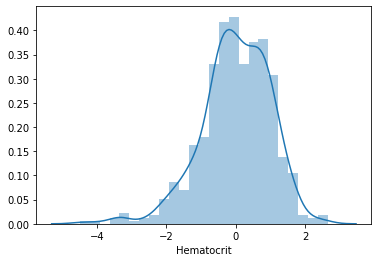

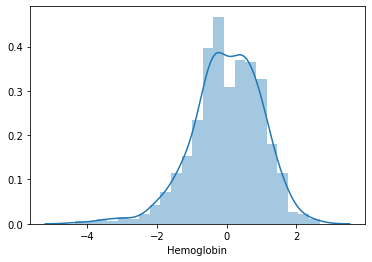

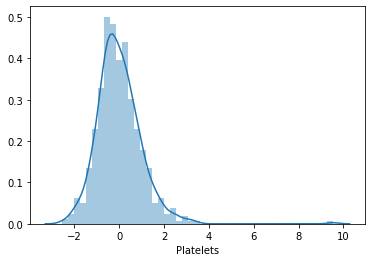

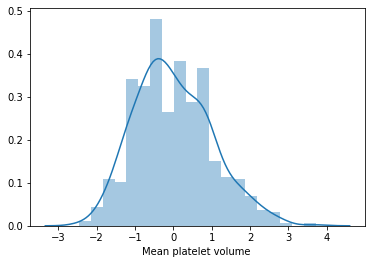

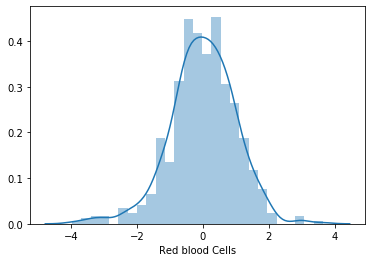

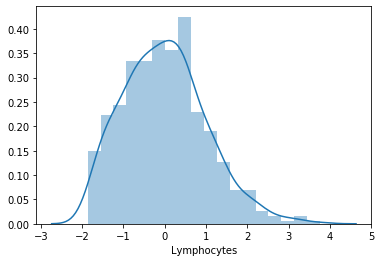

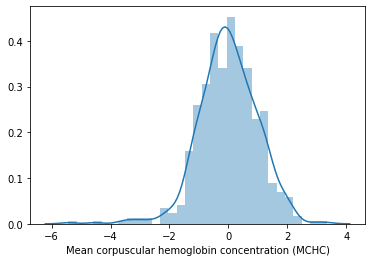

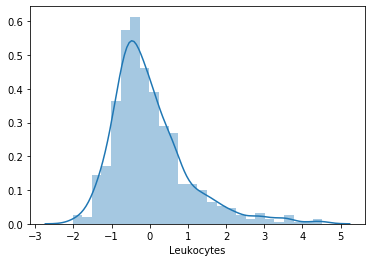

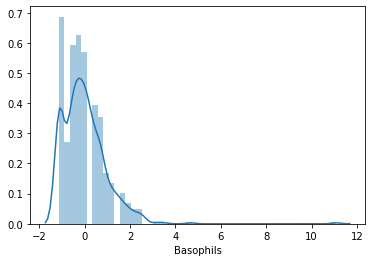

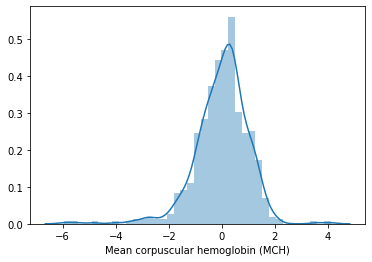

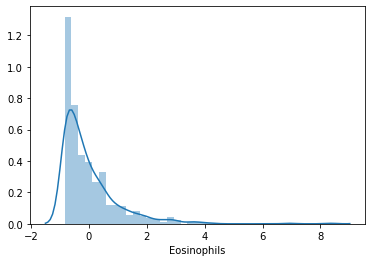

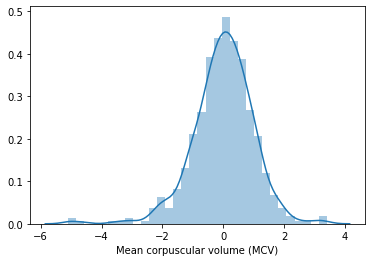

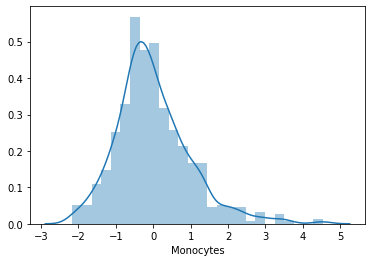

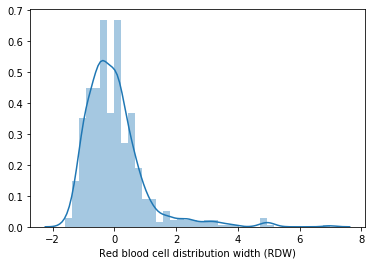

In [15]:
for col in df.select_dtypes("float"):
    plt.figure()
    sns.distplot(df[col])

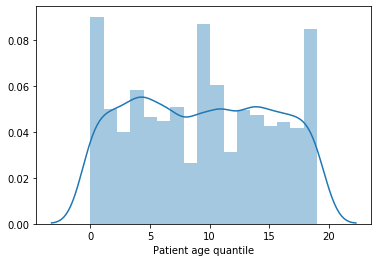

In [16]:
sns.distplot(df["Patient age quantile"])

In [17]:
df["Patient age quantile"].value_counts()

11    380
4     366
9     359
0     334
7     319
2     315
13    313
14    299
5     294
6     281
16    279
19    275
15    269
17    263
18    259
3     251
1     234
12    197
10    190
8     167
Name: Patient age quantile, dtype: int64

### Variables qualitatives ###

In [18]:
df["SARS-Cov-2 exam result"].unique()

array(['negative', 'positive'], dtype=object)

In [19]:
for col in df.select_dtypes("object"):
    print(f"{col :-<30}, {df[col].unique()}")

SARS-Cov-2 exam result--------, ['negative' 'positive']
Respiratory Syncytial Virus---, [nan 'not_detected' 'detected']
Influenza A-------------------, [nan 'not_detected' 'detected']
Influenza B-------------------, [nan 'not_detected' 'detected']
Parainfluenza 1---------------, [nan 'not_detected' 'detected']
CoronavirusNL63---------------, [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus--------, [nan 'detected' 'not_detected']
Coronavirus HKU1--------------, [nan 'not_detected' 'detected']
Parainfluenza 3---------------, [nan 'not_detected' 'detected']
Chlamydophila pneumoniae------, [nan 'not_detected' 'detected']
Adenovirus--------------------, [nan 'not_detected' 'detected']
Parainfluenza 4---------------, [nan 'not_detected' 'detected']
Coronavirus229E---------------, [nan 'not_detected' 'detected']
CoronavirusOC43---------------, [nan 'not_detected' 'detected']
Inf A H1N1 2009---------------, [nan 'not_detected' 'detected']
Bordetella pertussis----------, [nan 'not_detect

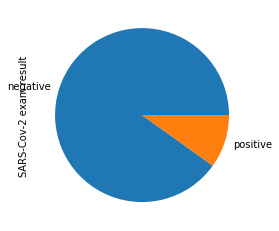

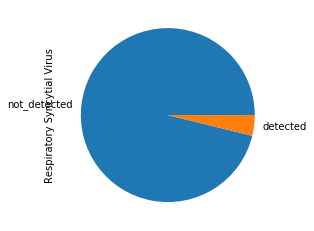

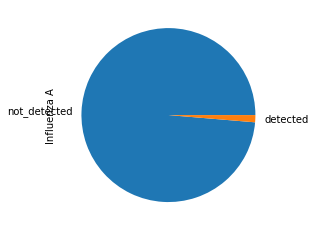

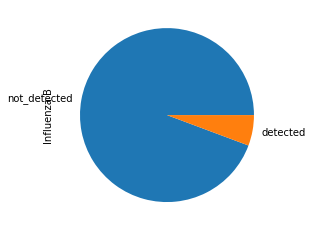

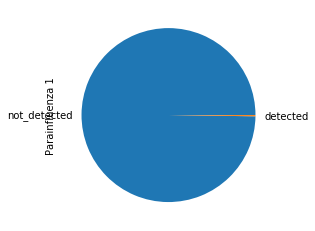

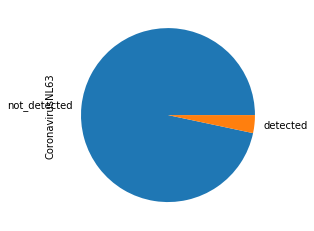

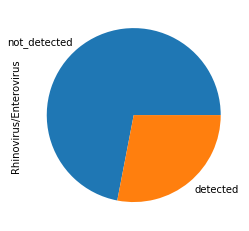

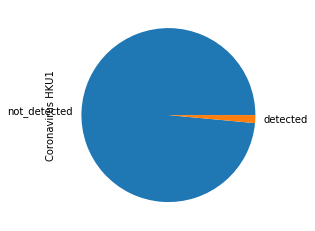

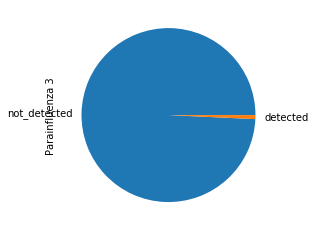

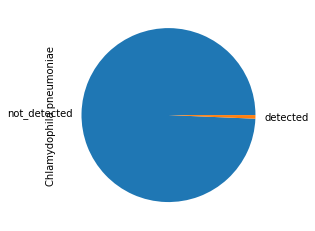

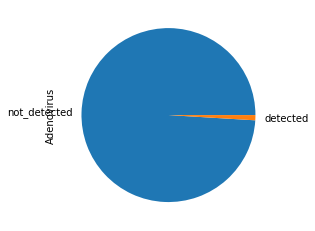

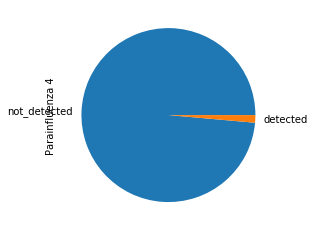

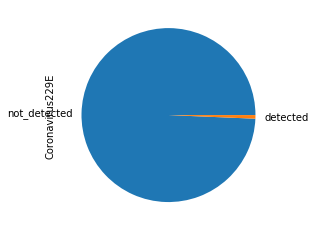

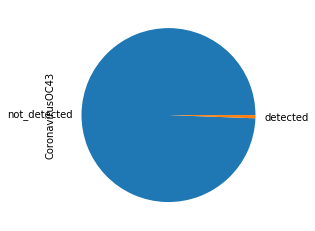

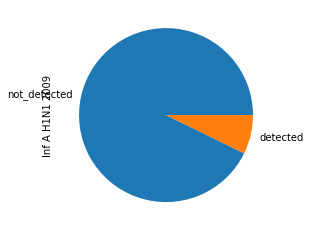

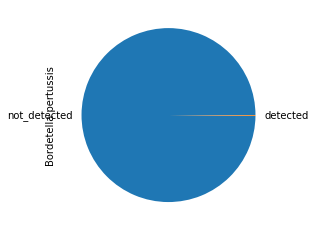

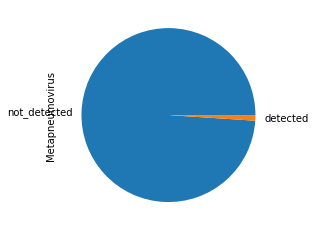

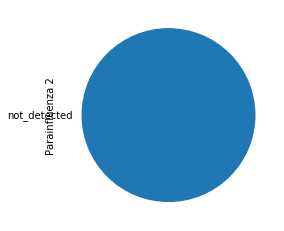

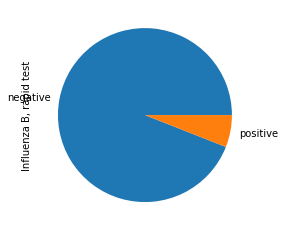

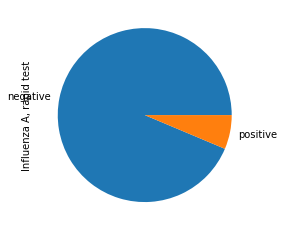

In [20]:
for col in df.select_dtypes("object"):
    plt.figure()
    df[col].value_counts().plot.pie()

### Relation target/variable ###

In [21]:
# Création de sous-ensembles positifs et négatifs

positive_df = df[df["SARS-Cov-2 exam result"] == "positive"]
negative_df = df[df["SARS-Cov-2 exam result"] == "negative"]

In [22]:
# Création des ensembles Blood et Viral

missing_rate = df.isna().sum()/df.shape[0]
blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]

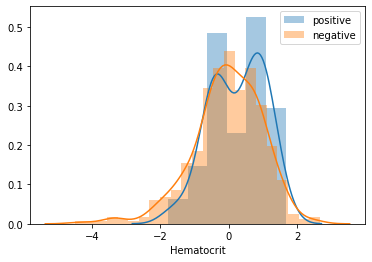

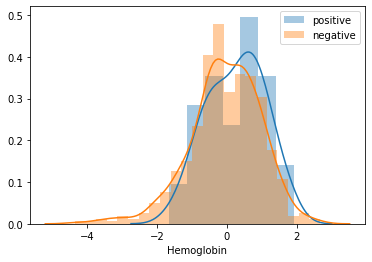

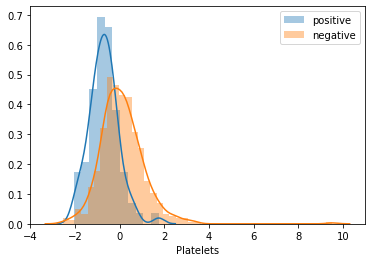

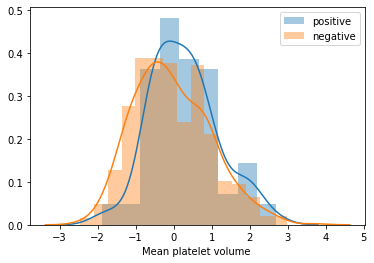

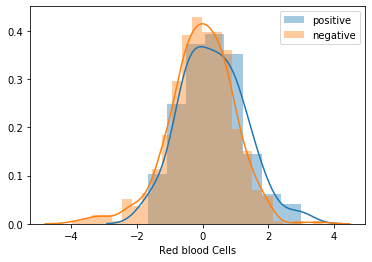

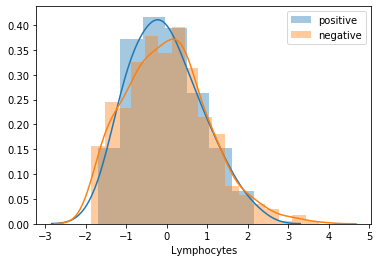

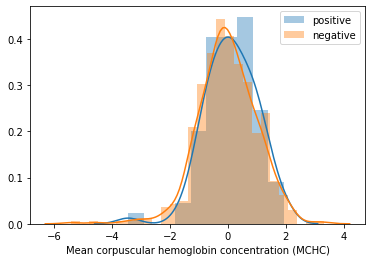

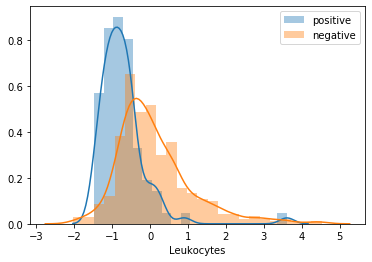

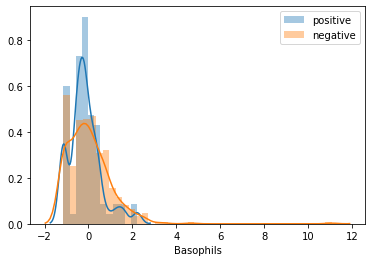

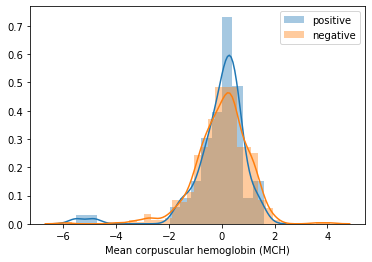

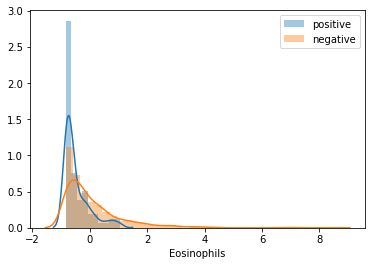

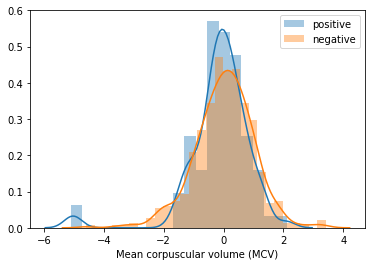

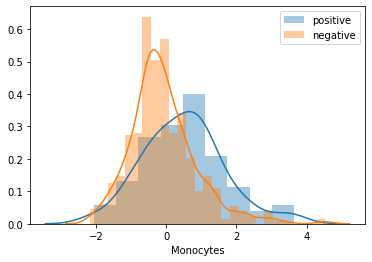

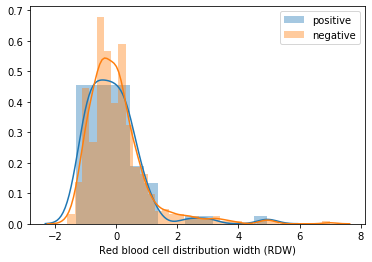

In [23]:
# Target / Blood

for col in blood_columns:
    plt.figure()
    sns.distplot(positive_df[col], label="positive")
    sns.distplot(negative_df[col], label="negative")
    plt.legend()

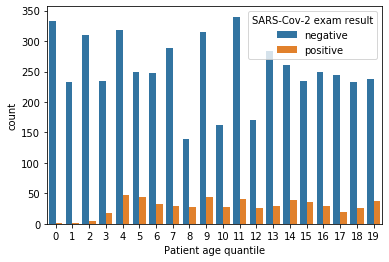

In [24]:
# Target / Age

sns.countplot(x="Patient age quantile", hue="SARS-Cov-2 exam result", data=df)

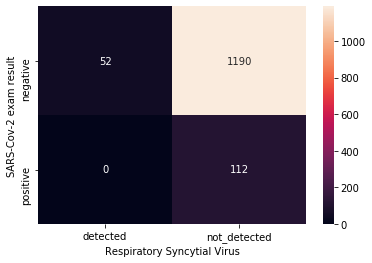

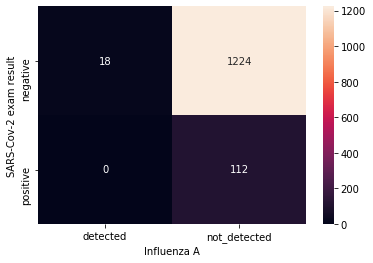

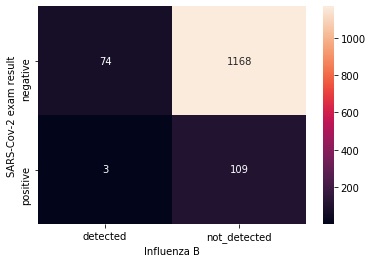

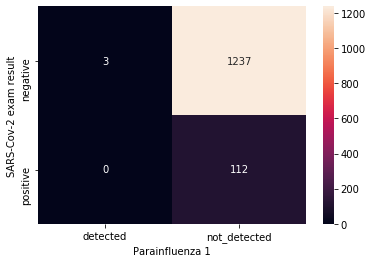

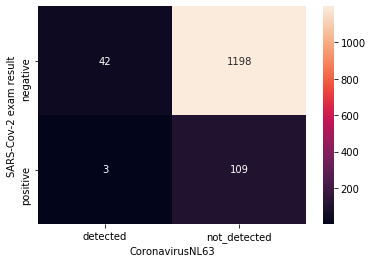

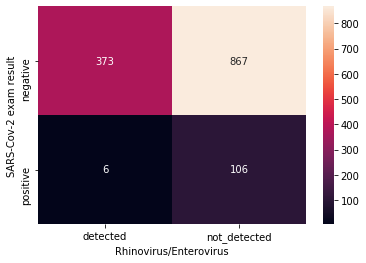

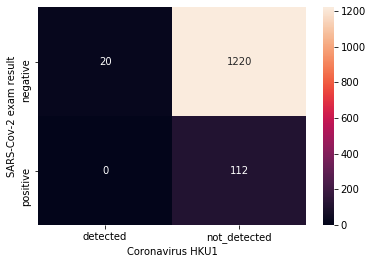

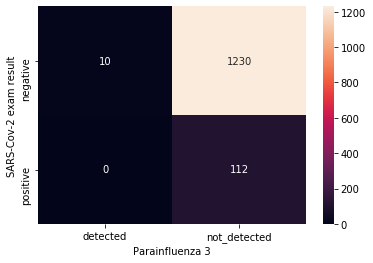

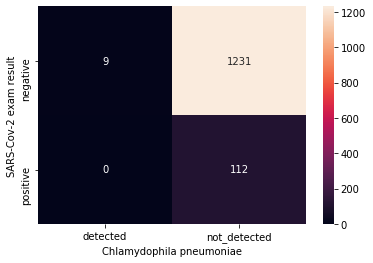

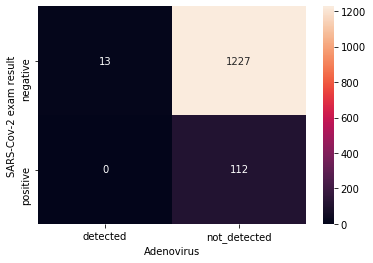

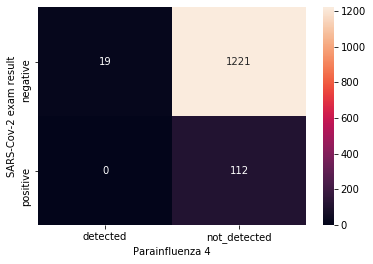

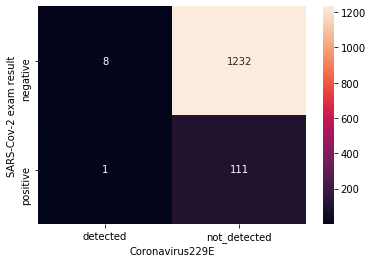

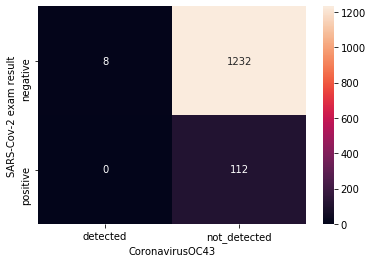

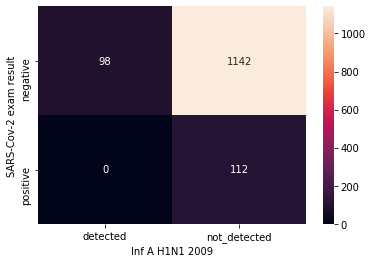

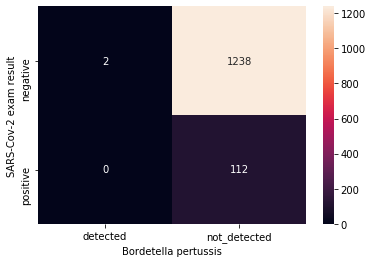

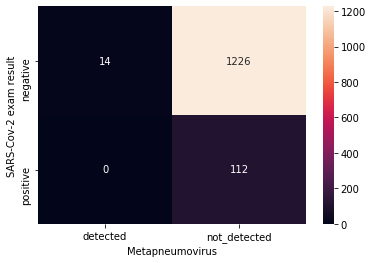

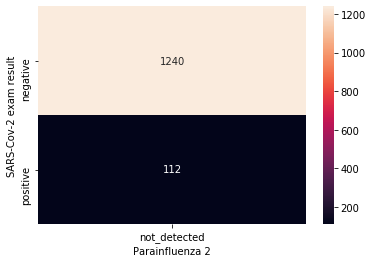

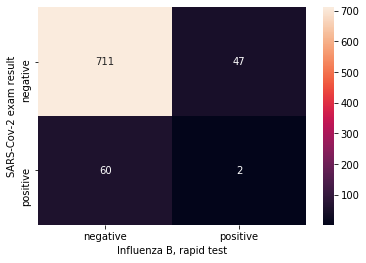

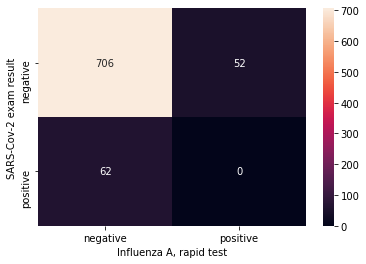

In [25]:
# Target / Viral
for col in viral_columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df["SARS-Cov-2 exam result"], df[col]), annot=True, fmt="d")

## 1.3. Analyse plus détaillée ##

### Relations variables/variables ###

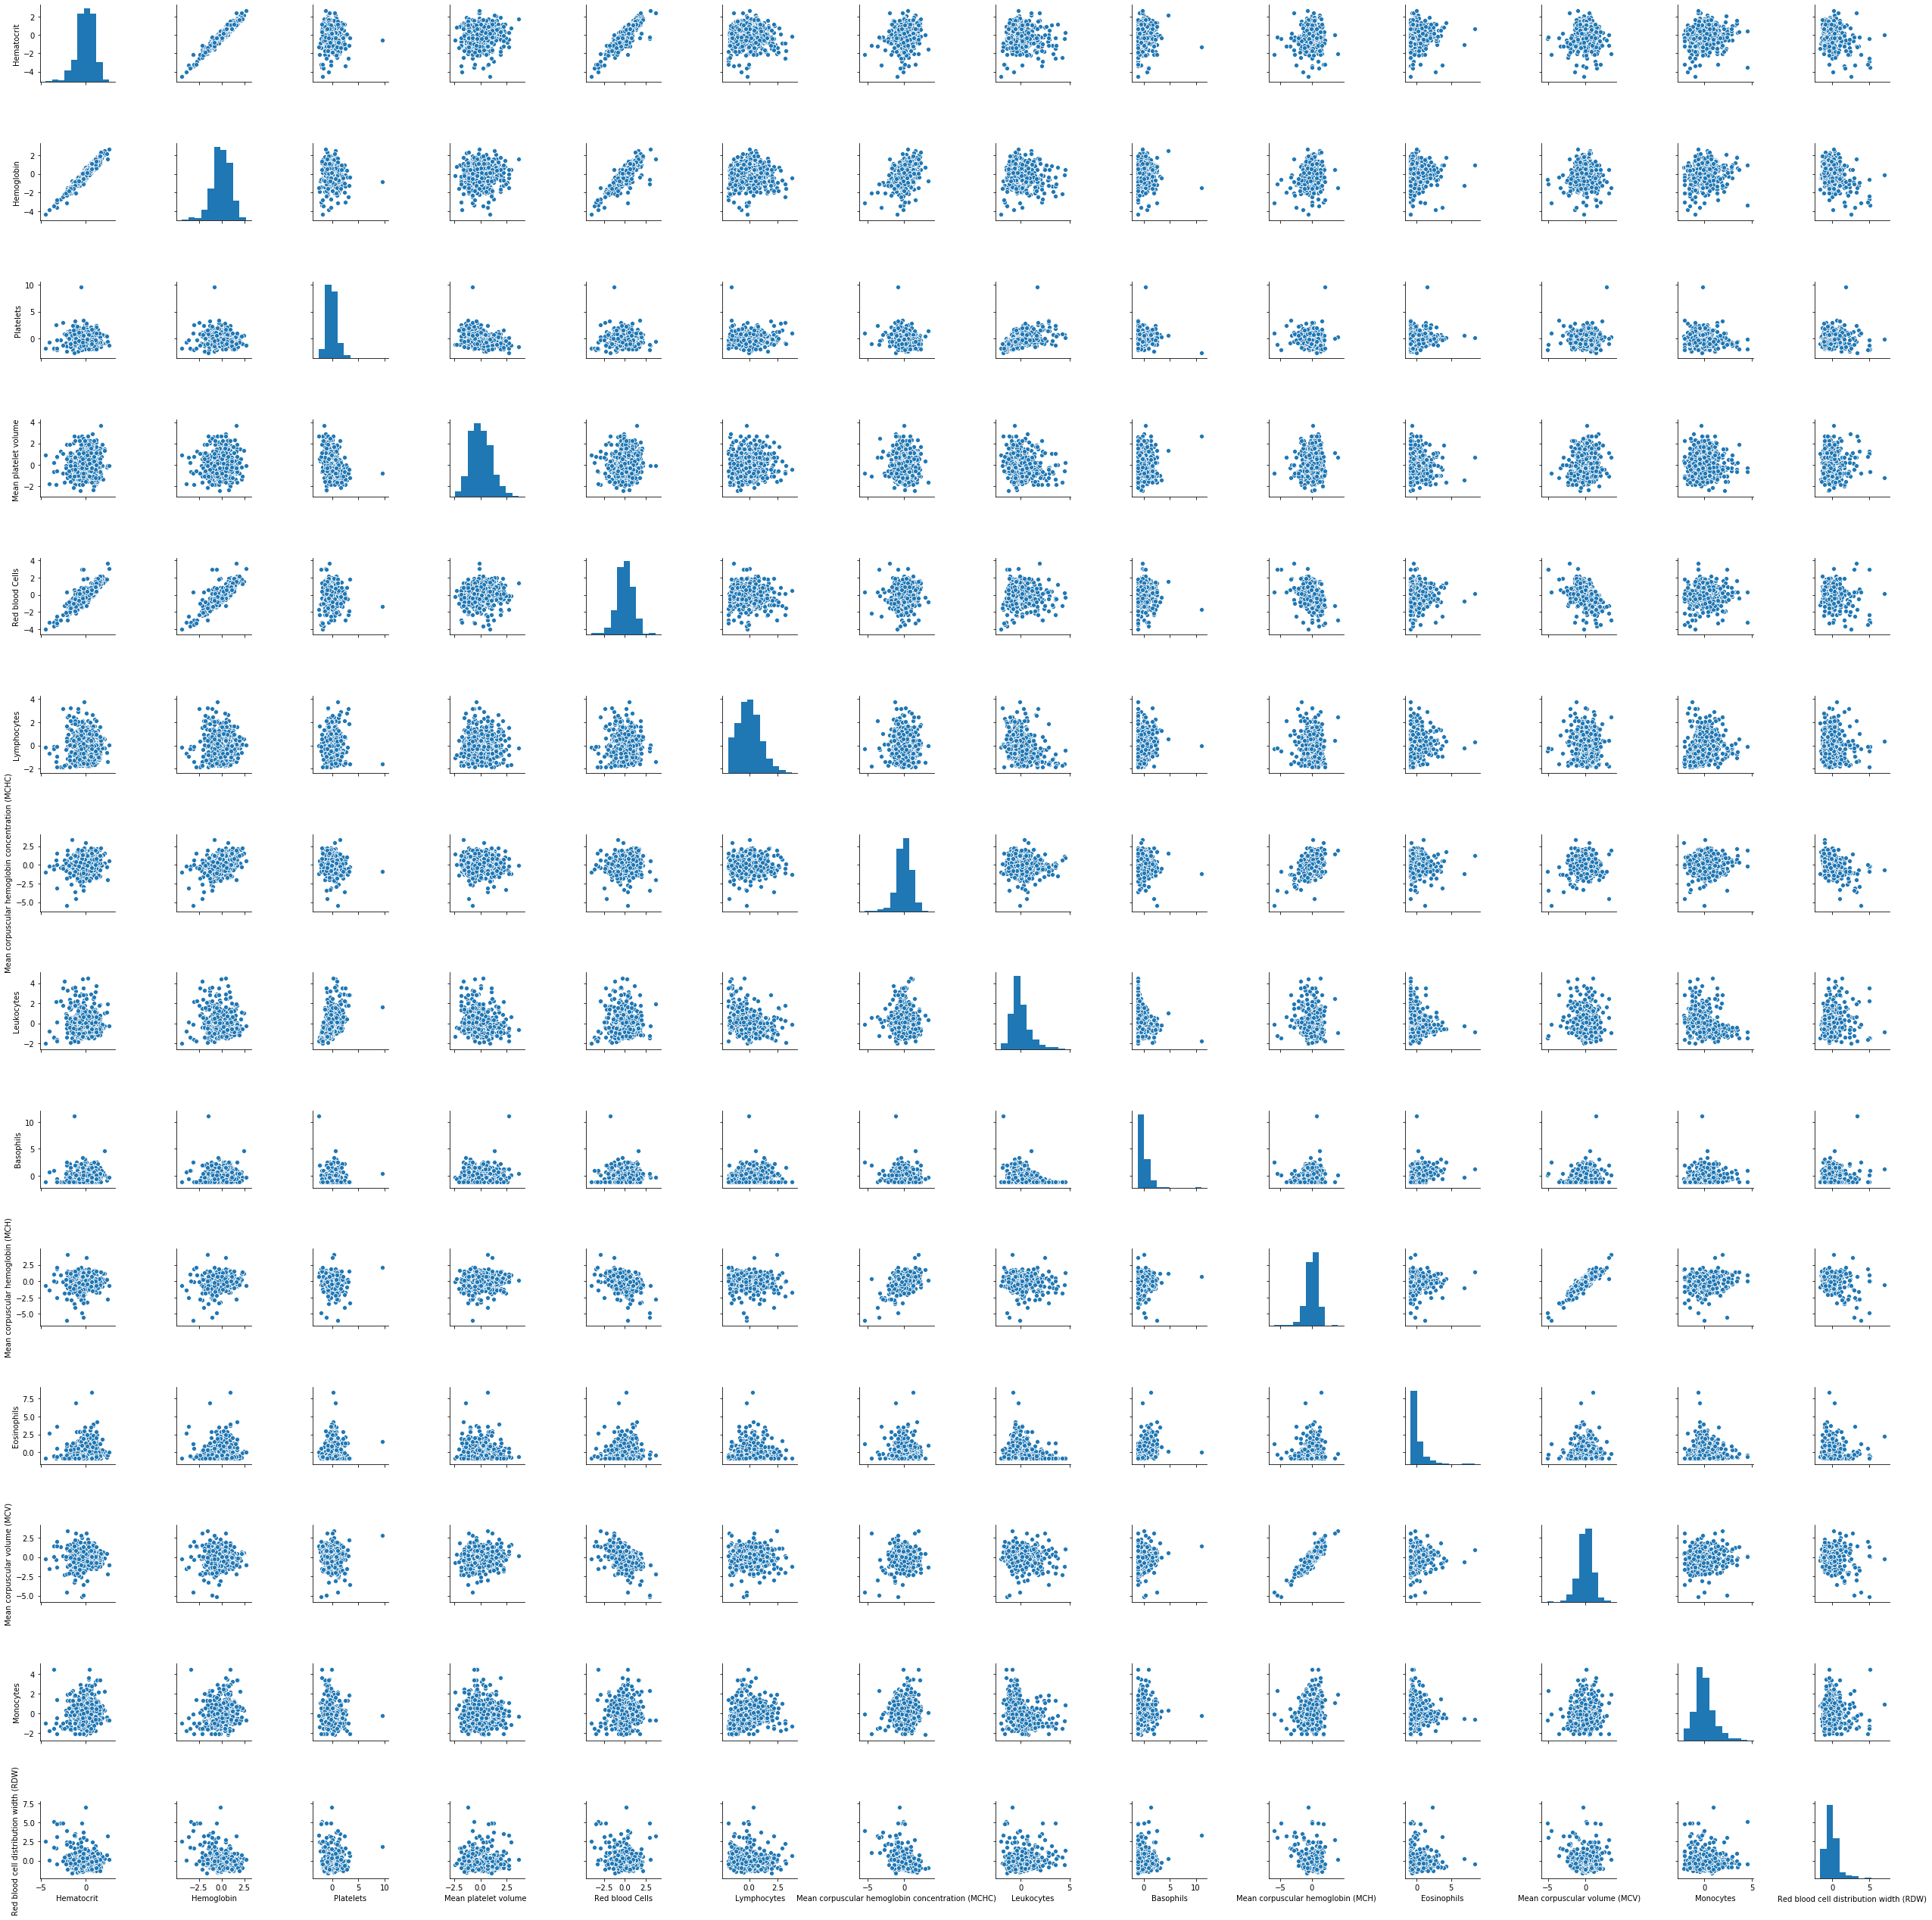

In [26]:
# relations taux sanguins
sns.pairplot(df[blood_columns])

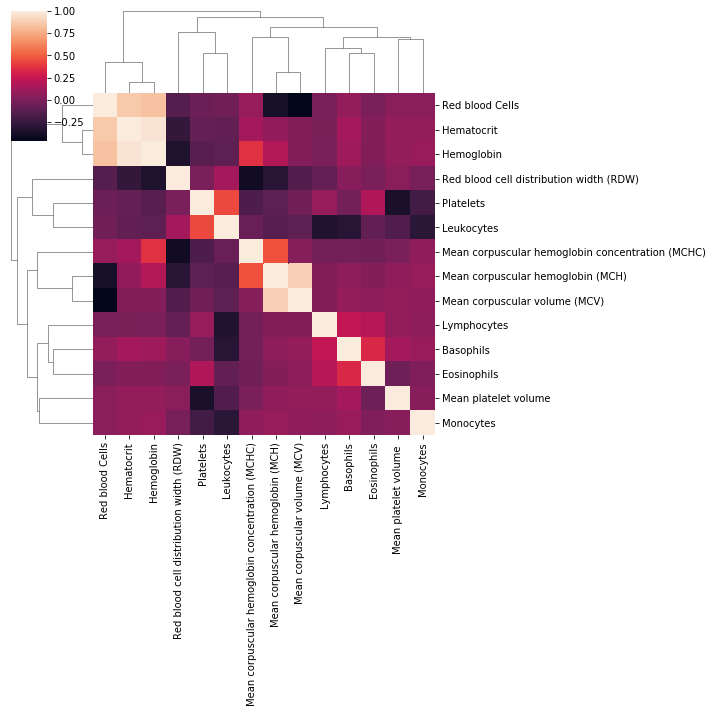

In [30]:
sns.clustermap(df[blood_columns].corr())

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To contr

<Figure size 432x288 with 0 Axes>

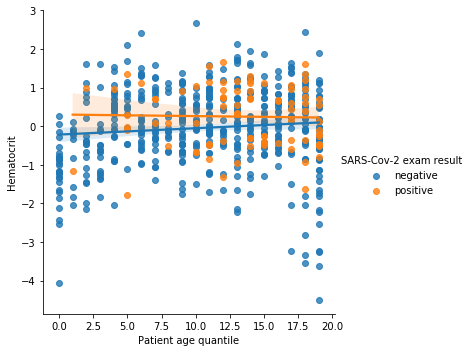

<Figure size 432x288 with 0 Axes>

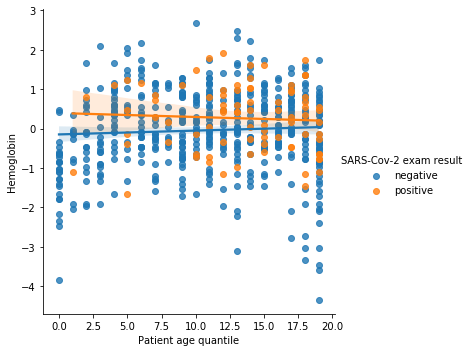

<Figure size 432x288 with 0 Axes>

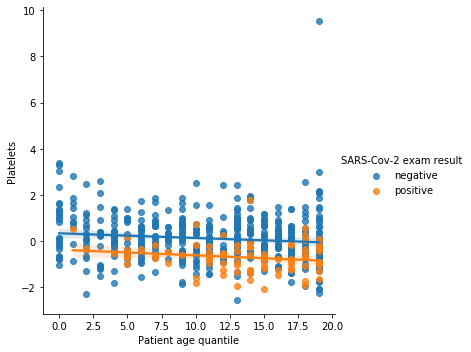

<Figure size 432x288 with 0 Axes>

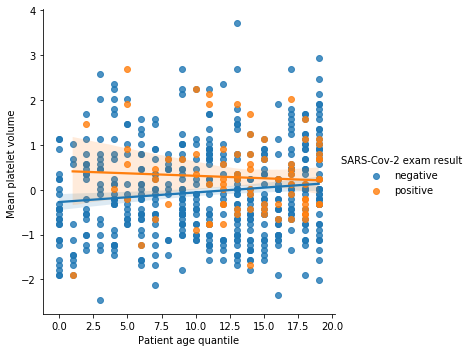

<Figure size 432x288 with 0 Axes>

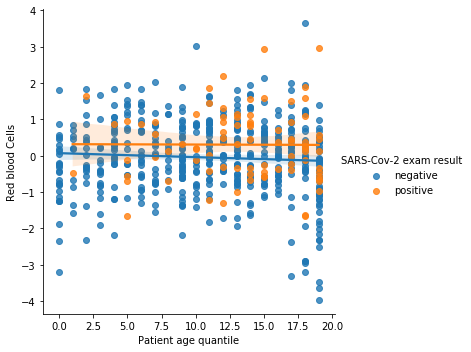

<Figure size 432x288 with 0 Axes>

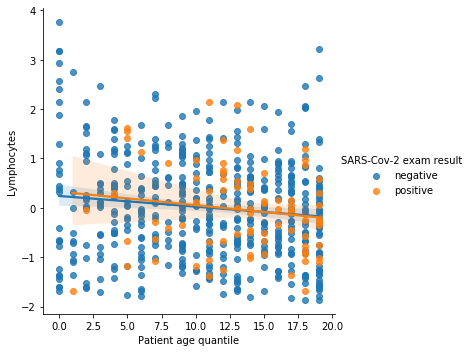

<Figure size 432x288 with 0 Axes>

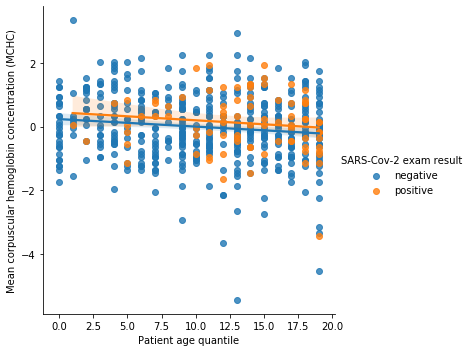

<Figure size 432x288 with 0 Axes>

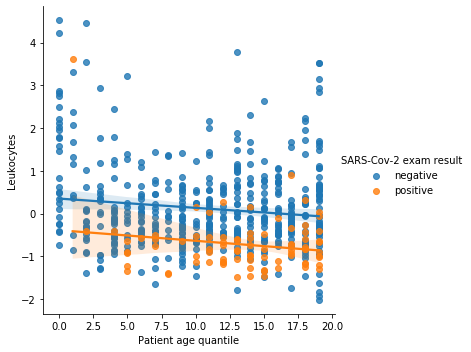

<Figure size 432x288 with 0 Axes>

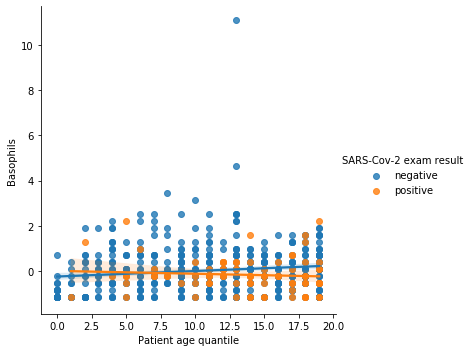

<Figure size 432x288 with 0 Axes>

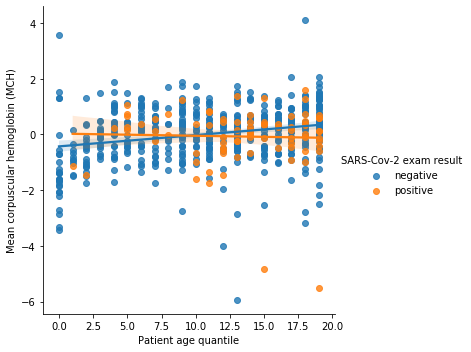

<Figure size 432x288 with 0 Axes>

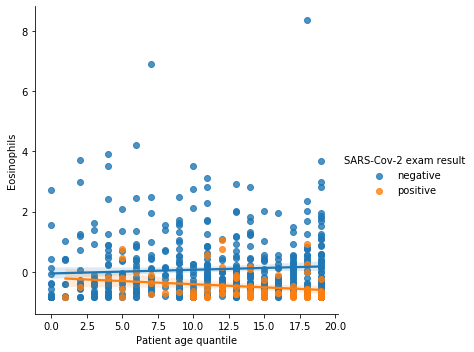

<Figure size 432x288 with 0 Axes>

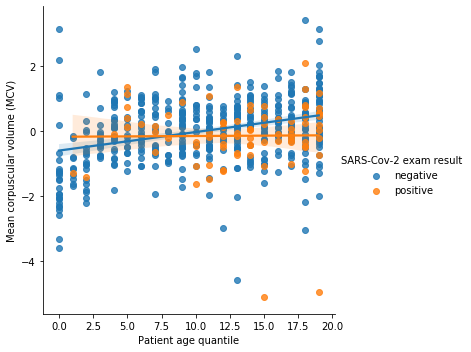

<Figure size 432x288 with 0 Axes>

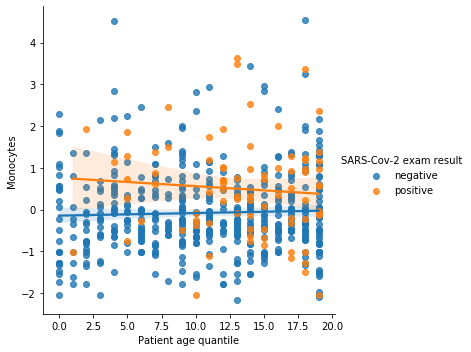

<Figure size 432x288 with 0 Axes>

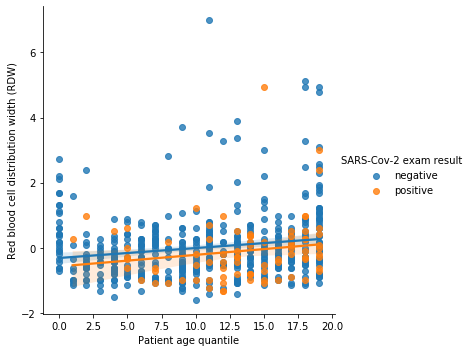

In [32]:
# relations age/sang

for col in blood_columns:
    plt.figure()
    sns.lmplot(x="Patient age quantile", y=col, hue="SARS-Cov-2 exam result", data=df)

In [35]:
df.corr()["Patient age quantile"].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

In [36]:
# relation influenza/rapid test

In [37]:
pd.crosstab(df["Influenza A"], df["Influenza A, rapid test"])

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

In [38]:
pd.crosstab(df["Influenza B"], df["Influenza B, rapid test"])

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

In [39]:
# relation viral/sanguin

In [44]:
## nouvelle variable "est malade"

df["est malade"] = np.sum(df[viral_columns[:-2]] == "detected", axis=1) >= 1

In [45]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


In [46]:
malade_df = df[df["est malade"] == True]
non_malade_df = df[df["est malade"] == False]

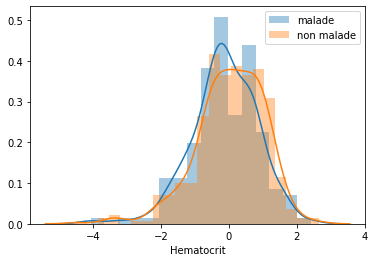

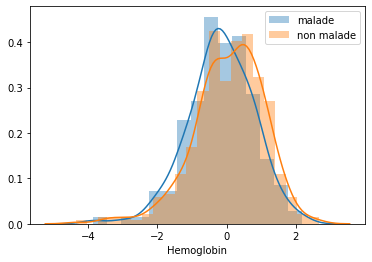

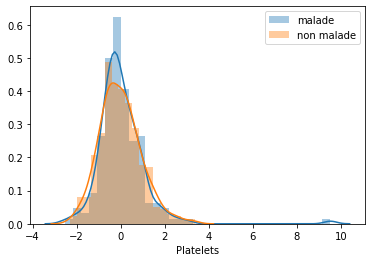

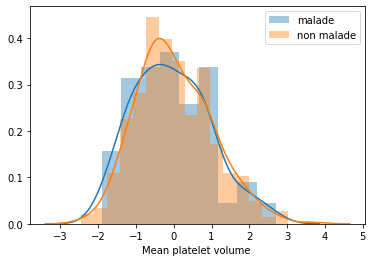

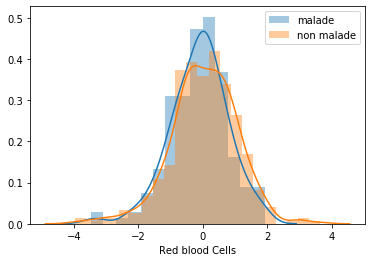

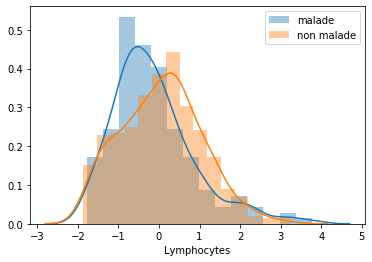

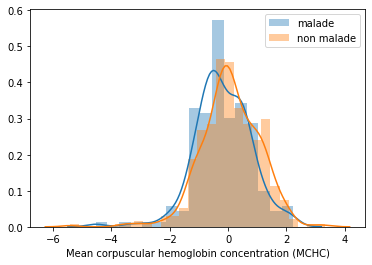

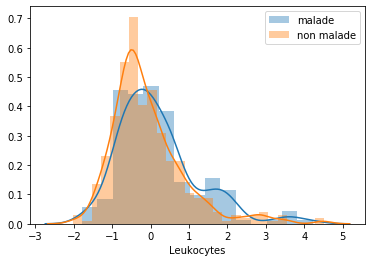

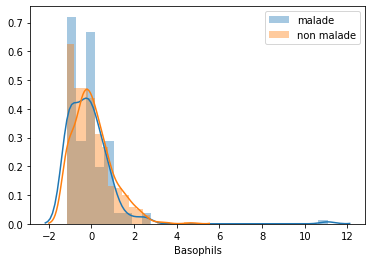

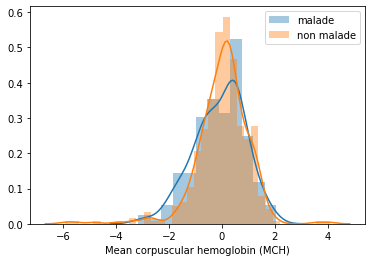

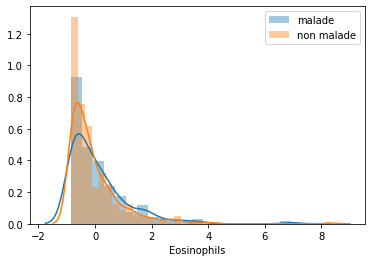

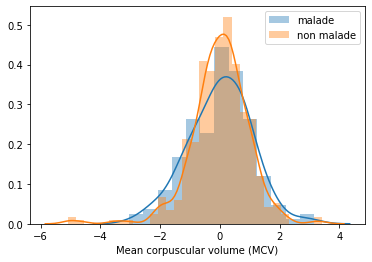

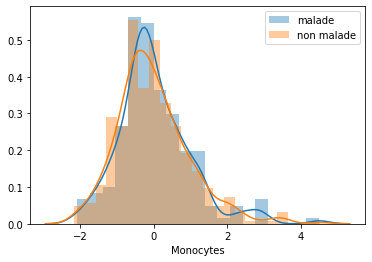

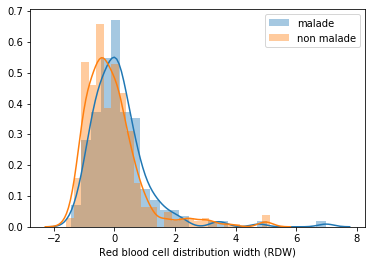

In [49]:
for col in blood_columns:
    plt.figure()
    sns.distplot(malade_df[col], label="malade")
    sns.distplot(non_malade_df[col], label="non malade")
    plt.legend()

In [60]:
# relation hospitalisation/blood

In [56]:
def hospitalisation(df):
    if df["Patient addmited to regular ward (1=yes, 0=no)"] == 1:
        return "surveillance"
    elif df["Patient addmited to semi-intensive unit (1=yes, 0=no)"] == 1:
        return "soins semi-intensives"
    elif df["Patient addmited to intensive care unit (1=yes, 0=no)"] == 1:
        return "soins intensifs"
    else:
        return "inconnu"

In [57]:
df["statut"] = df.apply(hospitalisation, axis=1)

In [58]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
Patient ID                                                     
44477f75e8169d2                    13               negative   
126e9dd13932f68                    17               negative   
a46b4402a0e5696                     8               negative   
f7d619a94f97c45                     5               negative   
d9e41465789c2b5                    15               negative   

                 Patient addmited to regular ward (1=yes, 0=no)  \
Patient ID                                                        
44477f75e8169d2                                               0   
126e9dd13932f68                                               0   
a46b4402a0e5696                                               0   
f7d619a94f97c45                                               0   
d9e41465789c2b5                                               0   

                 Patient addmited to semi-intensive unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Patient addmited to intensive care unit (1=yes, 0=no)  \
Patient ID                                                               
44477f75e8169d2                                                  0       
126e9dd13932f68                                                  0       
a46b4402a0e5696                                                  0       
f7d619a94f97c45                                                  0       
d9e41465789c2b5                                                  0       

                 Hematocrit  Hemoglobin  Platelets  Mean platelet volume   \
Patient ID                                                                  
44477f75e8169d2         NaN         NaN        NaN                    NaN   
126e9dd13932f68    0.236515    -0.02234  -0.517413               0.010677   
a46b4402a0e5696         NaN         NaN        NaN                    NaN   
f7d619a94f97c45         NaN         NaN        NaN                    NaN   
d9e41465789c2b5         NaN         NaN        NaN                    NaN   

                 Red blood Cells  Lymphocytes  \
Patient ID                                      
44477f75e8169d2              NaN          NaN   
126e9dd13932f68         0.102004     0.318366   
a46b4402a0e5696              NaN          NaN   
f7d619a94f97c45              NaN          NaN   
d9e41465789c2b5              NaN          NaN   

                 Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  \
Patient ID                                                                      
44477f75e8169d2                                               NaN         NaN   
126e9dd13932f68                                          -0.95079    -0.09461   
a46b4402a0e5696                                               NaN         NaN   
f7d619a94f97c45                                               NaN         NaN   
d9e41465789c2b5                                               NaN         NaN   

                 Basophils  Mean corpuscular hemoglobin (MCH)  Eosinophils  \
Patient ID                                                                   
44477f75e8169d2        NaN                                NaN          NaN   
126e9dd13932f68  -0.223767                          -0.292269     1.482158   
a46b4402a0e5696        NaN                                NaN          NaN   
f7d619a94f97c45        NaN                                NaN          NaN   
d9e41465789c2b5        NaN                                NaN          NaN   

                 Mean corpuscular volume (MCV)  Monocytes  \


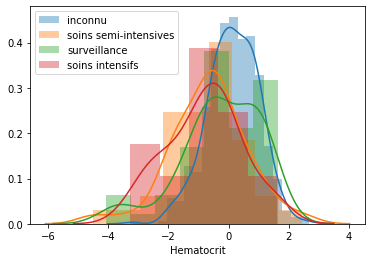

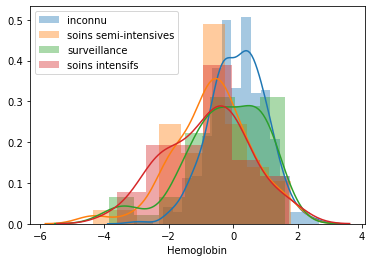

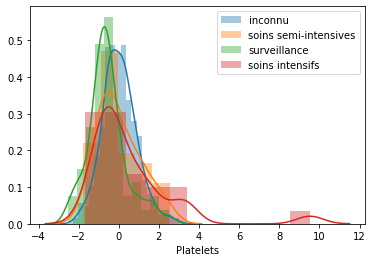

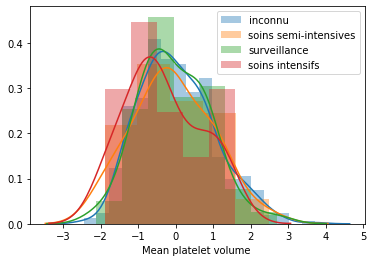

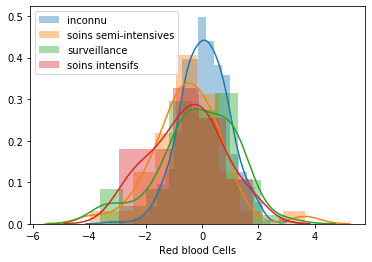

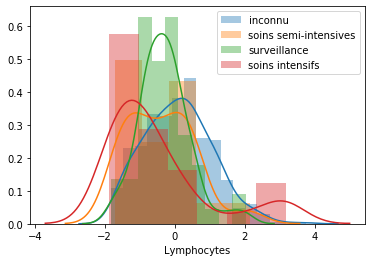

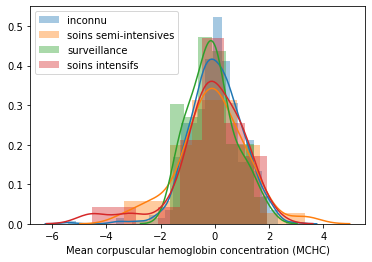

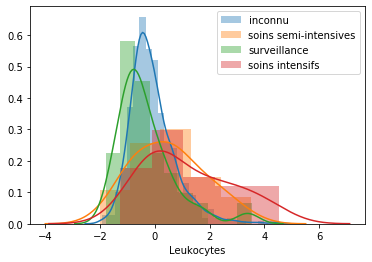

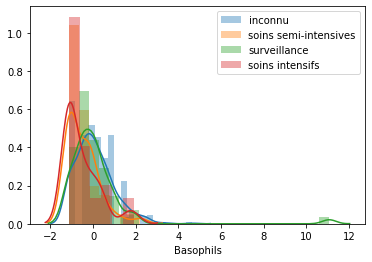

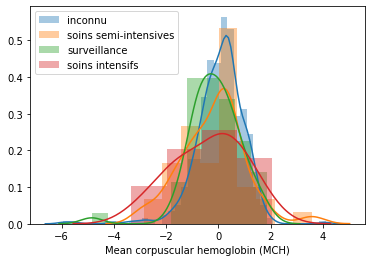

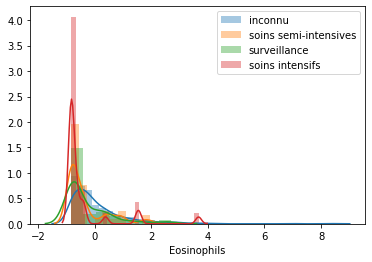

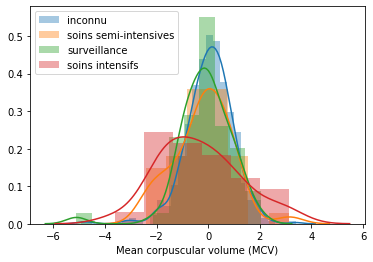

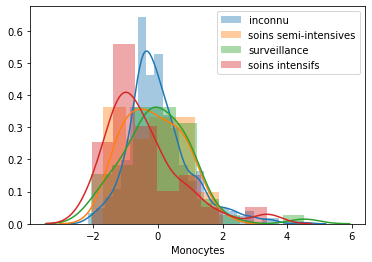

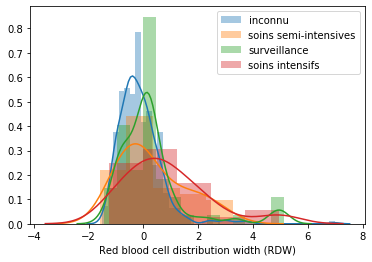

In [59]:
for col in blood_columns:
    plt.figure()
    for cat in df["statut"].unique():
        sns.distplot(df[df["statut"] == cat][col], label=cat)
    plt.legend()

### NaN analysis ###

In [61]:
df.dropna().count()

Patient age quantile                                     99
SARS-Cov-2 exam result                                   99
Patient addmited to regular ward (1=yes, 0=no)           99
Patient addmited to semi-intensive unit (1=yes, 0=no)    99
Patient addmited to intensive care unit (1=yes, 0=no)    99
Hematocrit                                               99
Hemoglobin                                               99
Platelets                                                99
Mean platelet volume                                     99
Red blood Cells                                          99
Lymphocytes                                              99
Mean corpuscular hemoglobin concentration (MCHC)         99
Leukocytes                                               99
Basophils                                                99
Mean corpuscular hemoglobin (MCH)                        99
Eosinophils                                              99
Mean corpuscular volume (MCV)           

In [62]:
df[blood_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [63]:
df[viral_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [64]:
df1 = df[viral_columns[:-2]]
df1["covid"] = df["SARS-Cov-2 exam result"]
df1.dropna()["covid"].value_counts(normalize=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

In [65]:
df2 = df[blood_columns]
df2["covid"] = df["SARS-Cov-2 exam result"]
df2.dropna()["covid"].value_counts(normalize=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


negative    0.864548
positive    0.135452
Name: covid, dtype: float64

## 1.4. Test d'hypothèse ##

### T-Test ###

In [66]:
from scipy.stats import ttest_ind

In [67]:
positive_df.shape

(558, 38)

In [70]:
balanced_ned = negative_df.sample(positive_df.shape[0])

In [71]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_ned[col].dropna(), positive_df[col].dropna())
    if p < alpha:
        return "H0 rejetée"
    else:
        return 0

In [73]:
for col in blood_columns:
    print(f"{col :-<50} {t_test(col)}")

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- 0
Platelets----------------------------------------- H0 rejetée
Mean platelet volume ----------------------------- 0
Red blood Cells----------------------------------- H0 rejetée
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 rejetée
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 rejetée
Mean corpuscular volume (MCV)--------------------- H0 rejetée
Monocytes----------------------------------------- 0
Red blood cell distribution width (RDW)----------- 0
